## 1.Import Libraries & Data

In [154]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [155]:
# Load data 'F:\ColleagueFakhri\Pembelajaran_Mesin\UAS\dataset\FiledataDataJumlahPendudukLanjutUsiaBerdasarkanJenisKelamindanUsiaPerKelurahan.csv'
data = pd.read_csv(r'F:\ColleagueFakhri\Pembelajaran_Mesin\UAS\dataset\FiledataDataJumlahPendudukLanjutUsiaBerdasarkanJenisKelamindanUsiaPerKelurahan.csv');
print(data.head());

   periode_data  tahun         nama_provinsi nama_kabupaten_kota  \
0          2015   2015  PROVINSI DKI JAKARTA       JAKARTA PUSAT   
1          2015   2015  PROVINSI DKI JAKARTA       JAKARTA PUSAT   
2          2015   2015  PROVINSI DKI JAKARTA       JAKARTA PUSAT   
3          2015   2015  PROVINSI DKI JAKARTA       JAKARTA PUSAT   
4          2015   2015  PROVINSI DKI JAKARTA       JAKARTA PUSAT   

  nama_kecamatan nama_kelurahan jenis_kelamin  usia  jumlah  
0    TANAH ABANG  KARET TENGSIN     Laki-laki    65     468  
1    TANAH ABANG     PETAMBURAN     Laki-laki    65     764  
2    TANAH ABANG   KEBON MELATI     Laki-laki    65     725  
3    TANAH ABANG   KEBON KACANG     Laki-laki    65     796  
4    TANAH ABANG   KAMPUNG BALI     Laki-laki    65     463  


## 2. Preprocessing

In [156]:
# Pastikan kolom "Jumlah Penduduk" dan "Kelurahan" ada pada dataset
data['tahun'] = pd.to_datetime(data['tahun'], format='%Y')
# Drop data tahun 2015-2017
data = data[~data['tahun'].dt.year.isin([2015, 2016, 2017])]


## 3. Proses Data

### 3.1 Pembagian(cluster) Untuk menentukan data yang paling dominan 

In [157]:
# Agregasi data jumlah penduduk lanjut usia per kabupaten/kota
agg_data_cluster = data.groupby('nama_kabupaten_kota')["jumlah"].sum().reset_index()

In [158]:
# Pengelompokan menggunakan K-Means
num_clusters = 3  # Tentukan jumlah cluster
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
agg_data_cluster['Cluster'] = kmeans.fit_predict(agg_data_cluster[['jumlah']])

f:\ColleagueFakhri\Pembelajaran_Mesin\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [159]:
# Tambahkan label untuk setiap cluster
cluster_labels = {
    0: 'Populasi Sedang',
    1: 'Populasi Tinggi',
    2: 'Populasi Rendah'
}
agg_data_cluster['Kategori Cluster'] = agg_data_cluster['Cluster'].map(cluster_labels)

# Output hasil cluster
print("Hasil Pengelompokan Per Kabupaten/Kota:")
print(agg_data_cluster.head())

Hasil Pengelompokan Per Kabupaten/Kota:
    nama_kabupaten_kota  jumlah  Cluster Kategori Cluster
0  ADM KEPULAUAN SERIBU    5481        2  Populasi Rendah
1         JAKARTA BARAT  613713        1  Populasi Tinggi
2         JAKARTA PUSAT  349702        0  Populasi Sedang
3       JAKARTA SELATAN  594404        1  Populasi Tinggi
4         JAKARTA TIMUR  755582        1  Populasi Tinggi


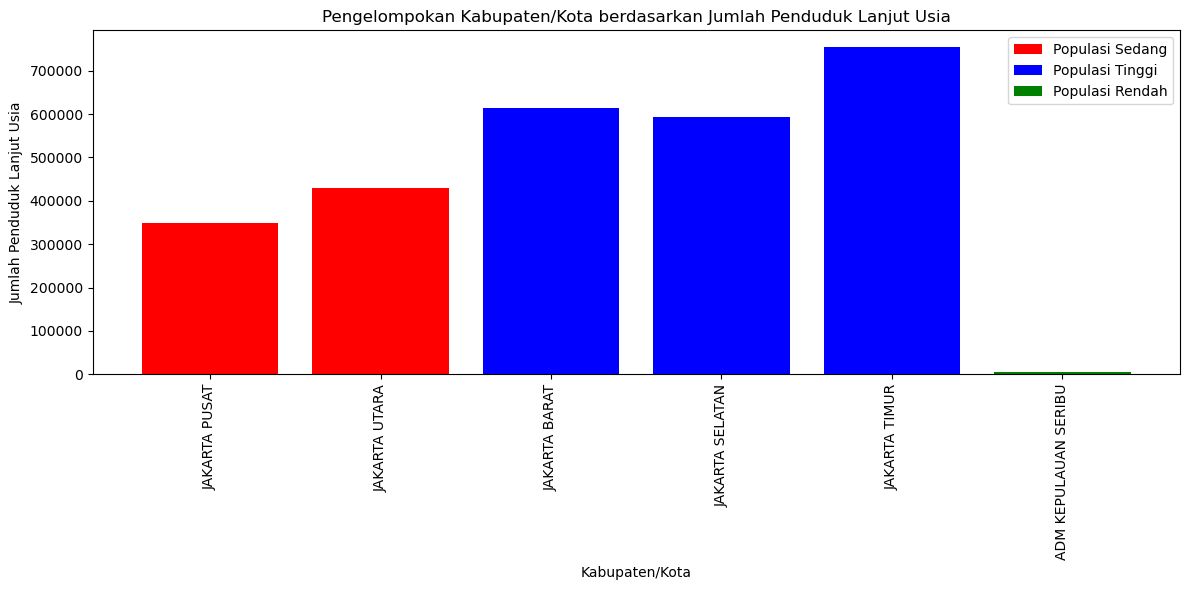

In [160]:
# Visualisasi hasil cluster
plt.figure(figsize=(12, 6))
colors = ['red', 'blue', 'green']
for cluster in range(num_clusters):
    cluster_data = agg_data_cluster[agg_data_cluster['Cluster'] == cluster]
    plt.bar(cluster_data['nama_kabupaten_kota'], cluster_data['jumlah'], 
                label=cluster_labels[cluster], color=colors[cluster])

plt.xticks(rotation=90)
plt.title('Pengelompokan Kabupaten/Kota berdasarkan Jumlah Penduduk Lanjut Usia')
plt.xlabel('Kabupaten/Kota')
plt.ylabel('Jumlah Penduduk Lanjut Usia')
plt.legend()
plt.tight_layout()
plt.show()

### 3.2 Membuat Rekomendasi kebijakan pada Data yang paling Tinggi

In [161]:
data = data[data['nama_kabupaten_kota'].str.contains('JAKARTA TIMUR', case=False, na=False)]

In [162]:
# Agregasi data jumlah penduduk lanjut usia per kelurahan
agg_data = data.groupby('nama_kecamatan')["jumlah"].sum().reset_index()

In [163]:
# Tentukan ambang batas untuk analisis
threshold_high_population = agg_data['jumlah'].quantile(0.75)  # Ambang batas 75%
threshold_low_population = agg_data['jumlah'].quantile(0.25)  # Ambang batas 25%

In [164]:
agg_data['Rekomendasi Kebijakan'] = np.where(
    agg_data['jumlah'] > threshold_high_population, 'Tambah Fasilitas Kesehatan',
    np.where(
        agg_data['jumlah'] < threshold_low_population, 'Tingkatkan Kegiatan Sosial',
        'Pantau dan Evaluasi'))

# Output hasil rekomendasi
print("Rekomendasi Kebijakan Publik untuk Jakarta Timur:")
print(agg_data.head())

Rekomendasi Kebijakan Publik untuk Jakarta Timur:
  nama_kecamatan  jumlah       Rekomendasi Kebijakan
0         CAKUNG  101535  Tambah Fasilitas Kesehatan
1       CIPAYUNG   57450         Pantau dan Evaluasi
2        CIRACAS   70028         Pantau dan Evaluasi
3    DUREN SAWIT  121059  Tambah Fasilitas Kesehatan
4     JATINEGARA   90457  Tambah Fasilitas Kesehatan


## 4 Visualisasi Data

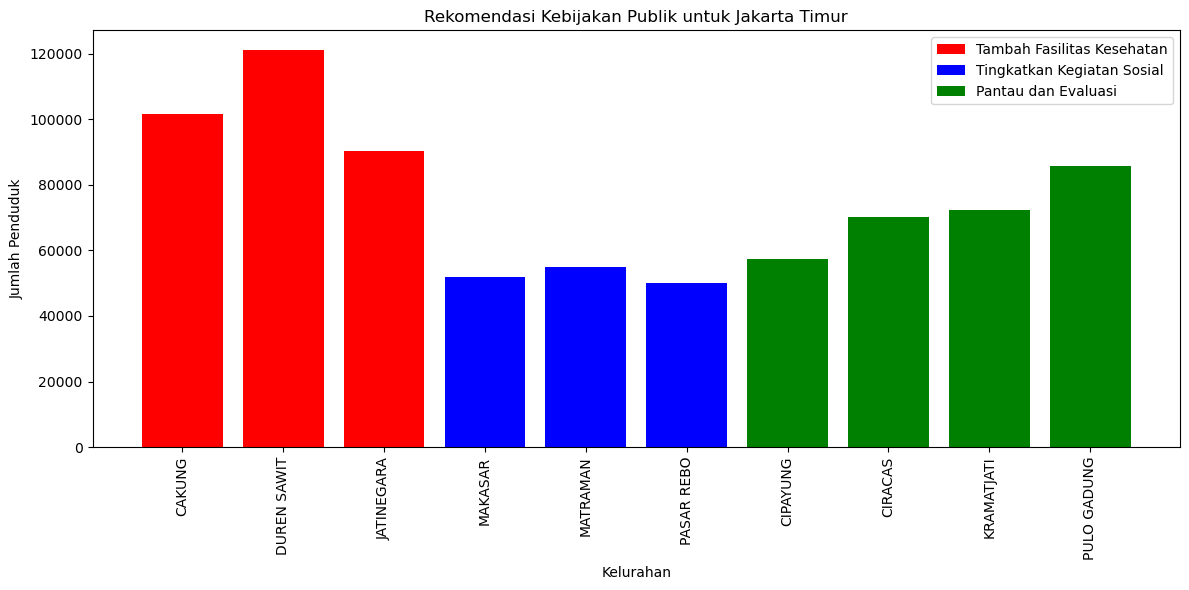

In [165]:
# Visualisasi hasil rekomendasi
plt.figure(figsize=(12, 6))
colors = {
    'Tambah Fasilitas Kesehatan': 'red',
    'Tingkatkan Kegiatan Sosial': 'blue',
    'Pantau dan Evaluasi': 'green'
}

for policy, color in colors.items():
    subset = agg_data[agg_data['Rekomendasi Kebijakan'] == policy]
    plt.bar(subset['nama_kecamatan'], subset['jumlah'], label=policy, color=color)

plt.xticks(rotation=90)
plt.title('Rekomendasi Kebijakan Publik untuk Jakarta Timur')
plt.xlabel('Kelurahan')
plt.ylabel('Jumlah Penduduk')
plt.legend()
plt.tight_layout()
plt.show()

In [166]:
# Simpan hasil ke file CSV
agg_data.to_csv('Rekomendasi_Kebijakan_Jakarta_Timur.csv', index=False)